# Ultra-High-Density Recording Explorer 

- Reads in an h5 file from Lead Labs Willow System (or anything that saves data as h5 files)
- Filters the data between 400 and 9500 Hz (in vivo recordings)
- Determines baseline noise levels in both the filtered and unfiltered traces
- Displays raw traces from each channel as they are arranged on the probe shank

## User Input

In [4]:
datafile = 'experiment_C20200330-175336.h5' # transferred experiment
fs = 30000 # sample rate
window = [0, 30] # time window of analysis (for filtering, 4 mins max for most computers)
chan_num = [0,64] # channels on the shank
columns = [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21], 
            [22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41], 
            [42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63]]         
lowcut = 400 # Hz for bandpass filter
highcut = 5000 # Hz for bandpass filter
order = 6 # For bandpass filter 

- Assumes this python notebook, the data file, and the imp. file are in same dir
- `datafile` = raw h5 file you transferred from the datanode SSD drive
- `fs` = sample rate
- `window` = [start_time, end_time] of analysis window (in seconds, 4 min max usually)
- `chan_num` = [start_channel, end_channel] where numbering starts at 0 and the last item in the list is not included
     - For channels 0-64 on shank1, `chan_num` = [0,64]. shank2 = [64, 128]
- `columns` = the probe map in array form (or list of lists). 
   - Each set (denoted by interior brackets) is a list of channels in that column
   - Left is closer to the tip of the shank (pointy end)
   - Ingrids probes have 3 rows, with 21,20, and 21 channels, respectively
   - The grid plotting routines take this into account
   - This variable may change from probe to probe
   - Make sure you check the `columns` variable against the probe map every time
- `lowcut` = lower limit of the bandpass filter
- `highcut` = upper limit of the bandpass filter
- `order` = order of the filtering function. >3 is in the flat part of the curve. 5 and 6 are in the middle.

## Import Dependencies

In [5]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.signal import butter, sosfiltfilt, sosfreqz
import time
import pandas as pd

## Read in h5 file

In [6]:
columns = np.array(columns) # makes a numpy array from the list of lists for speed
channels = list(np.arange(chan_num[0], chan_num[1])) # list of channels for the current shank
f_data = h5py.File(datafile, 'r') # Read in the h5 file
xs = f_data.get('sample_index') # time in datapoints (x)
ys = f_data.get('channel_data')  # actual data in raw format, must be scaled to microvolts (y)
xs = xs[window[0]*fs:window[1]*fs] # keep only the time window we specified in user input
ys = ys[window[0]*fs:window[1]*fs, channels] * 0.195  # keep only the time window and channel range specified
display (HTML("<hr><h4>Data consists of " + str(ys.shape[1]) + 
              " columns of data (channels, x) and " + str(ys.shape[0]) + 
              " rows of data (measurements, y)." + "The recording is " +
              str(round(ys.shape[0]/(fs * 60),3)) + " mins long. <hr>"))
f_data.close()

## Bandpass Filter (butterworth) of Experimental Data
- channels are reset to [0,64] regardless of shank number since we excluded the other channels

In [7]:
channels = list(np.arange(0,64)) # Channels reset to 0-63 after import. Ch 64 is now Ch0 in memory
filtered = pd.DataFrame()

In [8]:
def butter_bandpass(lowcut, highcut, fs, order=order):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfiltfilt(sos, data)
        return y

def get_filtered (df):
    lowcut = 400
    highcut = 5000
    display (HTML("<h4>Analyzing channel: "))
    for chan in channels:
        print(chan, end = ' ')
        order = 6
        x = np.arange(len(ys[:,chan]))
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = sosfreqz(sos, worN=2000)
        filtered[chan] = butter_bandpass_filter(ys[:,chan], lowcut, highcut, fs, order=order)
    return df

filtered = get_filtered(filtered)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

## Analyze noise of unfiltered experimental data
- default is analysis of the first second in the recording

In [9]:
mean_start = 0   # Beginning of time window for noise analysis
mean_end = 30000 # End of time window for noise analysis

In [10]:
means = []
medians = []
sds = []
rngs = []

for chan in channels:
    means.append(np.mean(ys[mean_start:mean_end, chan]))
    medians.append(np.median(ys[mean_start:mean_end, chan]))
    sds.append(np.std(ys[mean_start:mean_end, chan]))
    rngs.append(np.ptp(ys[mean_start:mean_end, chan]))

unfiltered_stats = pd.DataFrame ({'means': means, 'medians': medians, 'sds': sds, 'rngs': rngs})
display(HTML(unfiltered_stats.head().to_html()))

,means,medians,sds,rngs
0,6399.518359,6392.100,123.447239,1018.290
1,6400.078666,6396.390,114.159562,975.780
2,6397.838473,6387.810,136.880774,1419.795
3,6398.058453,6396.195,124.337490,1023.750
4,6399.920664,6394.440,119.891008,1032.915


## Analyze noise of filtered experiment

In [11]:
means = []
medians = []
sds = []
rngs = []

for chan in channels:
    means.append(np.mean(filtered.iloc[mean_start:mean_end, chan]))
    medians.append(np.median(filtered.iloc[mean_start:mean_end, chan]))
    sds.append(np.std(filtered.iloc[mean_start:mean_end, chan]))
    rngs.append(np.ptp(filtered.iloc[mean_start:mean_end, chan]))

filtered_stats = pd.DataFrame ({'means': means, 'medians': medians, 'sds': sds, 'rngs': rngs})
display(HTML(filtered_stats.head().to_html()))

,means,medians,sds,rngs
0,-0.010103,-0.428165,50.146673,740.860510
1,-0.012471,0.566301,45.555771,504.181118
2,0.004572,-1.763404,49.535605,611.256443
3,0.001528,1.633728,50.441397,534.919369
4,-0.005854,0.128274,48.141641,589.875436


## Save the filtered and noise stats to a new file
- This will make it easier to fetch the data later on without having to reload the whole thing
- This takes about 5-15 minutes per file
- Use this file in `h5_spikedetector.ipynb` and `h5_spikeviewer.ipynb`

In [12]:
hf = h5py.File(datafile.replace('.h5', '_filtered_' + str(chan_num[1]) + '.h5'), 'w')
hf.create_dataset('sample_index', data = list(range(0,len(filtered.iloc[:,0]))))
hf.create_dataset('channel_data', data = filtered)
hf.create_dataset('filtered_stats', data = filtered_stats)
hf.create_dataset('unfiltered_stats', data = unfiltered_stats)
hf.close()

## Plot 2 mins of a single channel
- useful for finding regions of activity quickly
- `start_time` and `end_time` are in seconds
- `channel` = choose a channel between 0-63
   - this refers to the channel on the current shank only
   - if it's shank 2,3,or 4, the channel range is still 0-63 because we're only looking at one shank at a time

In [13]:
channel = 0     # 0-63 regardless of shank#
start_time = 0  # In seconds
end_time = 0.02 # In seconds

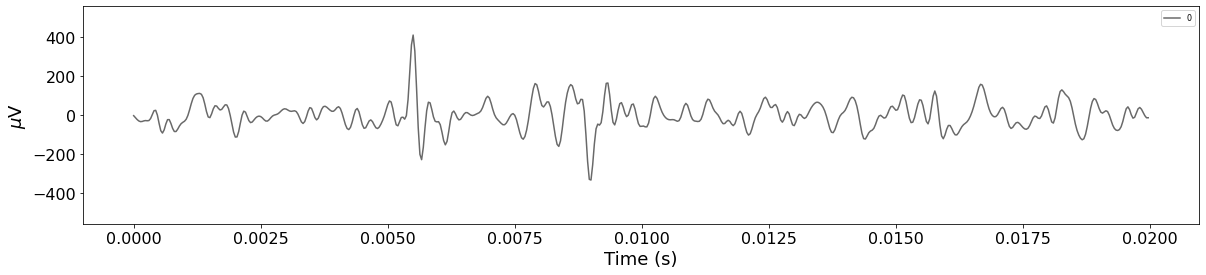

In [14]:
def single_plot(chan, start, end):
    start = int(start * fs)
    end = int(end * fs)
    display(HTML('<hr><h4>Plotting channel: '))
    fig, ax = plt.subplots (figsize =(20,4))
    ax.plot(xs[start:end]/fs, filtered.iloc[start:end,chan], color = 'dimgray', 
                            label=str(chan))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc = 'upper right', fontsize = 8, shadow = False)
    ax.set_ylim(filtered_stats.means[chan] - filtered_stats.rngs[chan]*0.75, 
                              filtered_stats.means[chan] + filtered_stats.rngs[chan]*0.75)
    ax.set_ylabel(r'$\mu$V', fontsize = 18)
    ax.set_xlabel('Time (s)', fontsize = 18)
    ax.tick_params(labelsize = 16)

single_plot(channel, start_time, end_time) 

## Plot unfiltered experimental data as grid

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

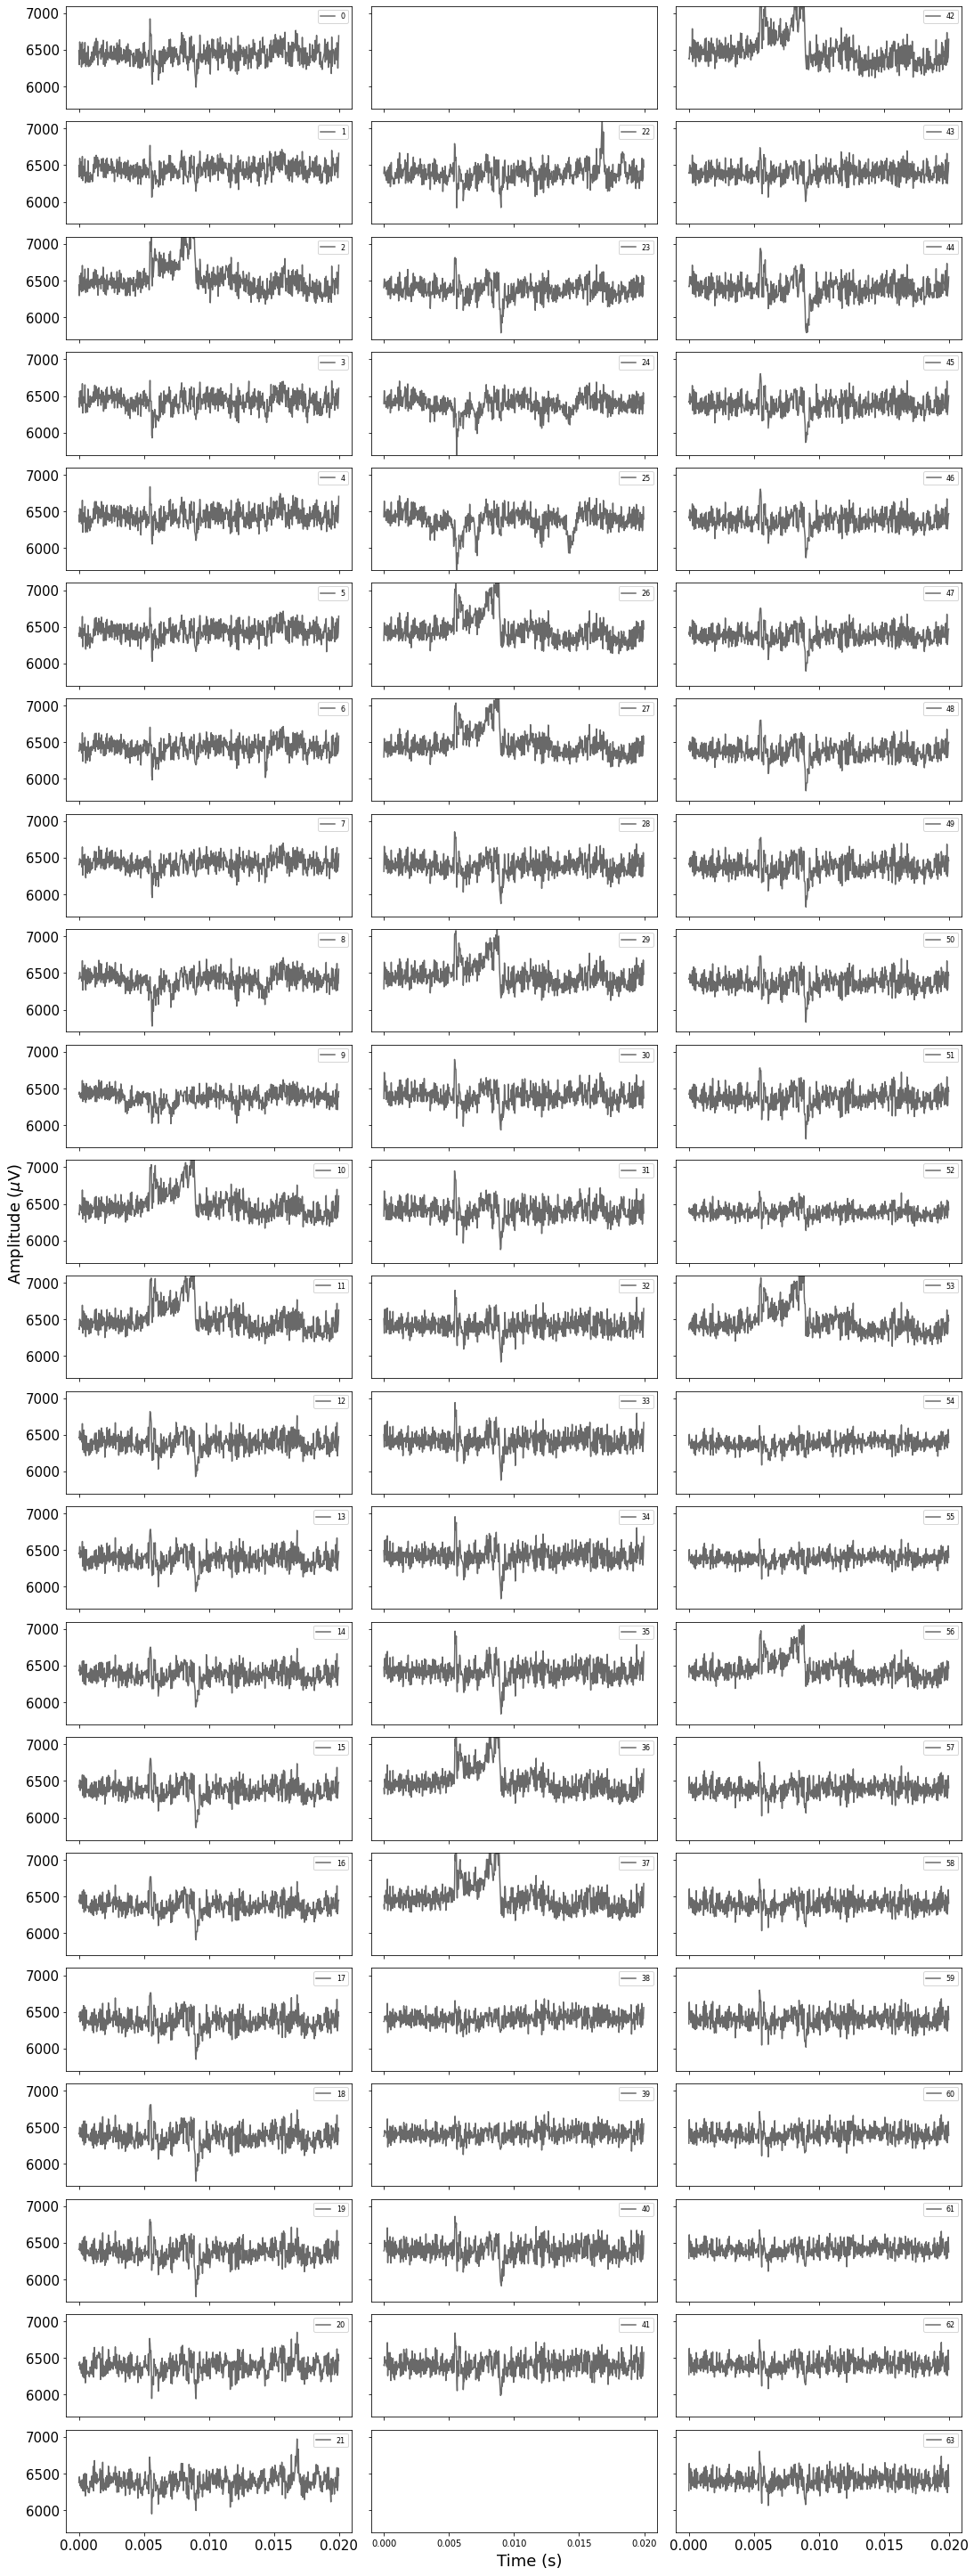

In [15]:
def grid_plot_unfiltered(columns, start, end):
    start = int(start*30000)
    end = int(end*30000)
    display(HTML('<hr><h4>Plotting channel: '))
    fig, ax = plt.subplots (len(columns[0]),int(columns.shape[0]), figsize =(15,40), sharex = True, sharey = True)
    j = 0
    for j in np.arange (0,columns.shape[0]):
        for i,col in enumerate(columns[j]): 
            if j == 1: # Offset for middle row (grid is 66 panels, but we only have 64 channels. Middle row is shorter) 
                i = i + 1
            print(col, end = ' ')
            ax[i][j].plot(xs[start:end]/fs, ys[start:end,col], color = 'dimgray', 
                            label=str(col)) # Unfiltered Signal
            handles, labels = ax[i][j].get_legend_handles_labels()
            ax[i][j].legend(handles, labels, loc = 'upper right', fontsize = 8, shadow = False)
            y_lims = ax[i][j].get_ylim()
            ax[i][j].set_ylim(y_lims[0] - abs(y_lims[0]) * 0.1, y_lims[1] + abs(y_lims[1]) * 0.1)
            ax[i][j].set_ylim(unfiltered_stats.means[col] - unfiltered_stats.rngs[col]*0.75, 
                              unfiltered_stats.means[col] + unfiltered_stats.rngs[col]*0.75)
            ax[i][j].tick_params (labelsize = 15)
            plt.tight_layout()
    fig.text(0.0, 0.5, r'Amplitude ($\mu$V)', ha='center', rotation='vertical', fontsize = 18)
    fig.text(0.5, 0.0, 'Time (s)', va='center',  fontsize = 18)
    plt.savefig (datafile.replace('.h5','_unfiltered' + str(chan_num[1]) + '.png'))
    display(HTML('<hr>'))

grid_plot_unfiltered(columns, start_time, end_time)

## Plot filtered experimental data as grid

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

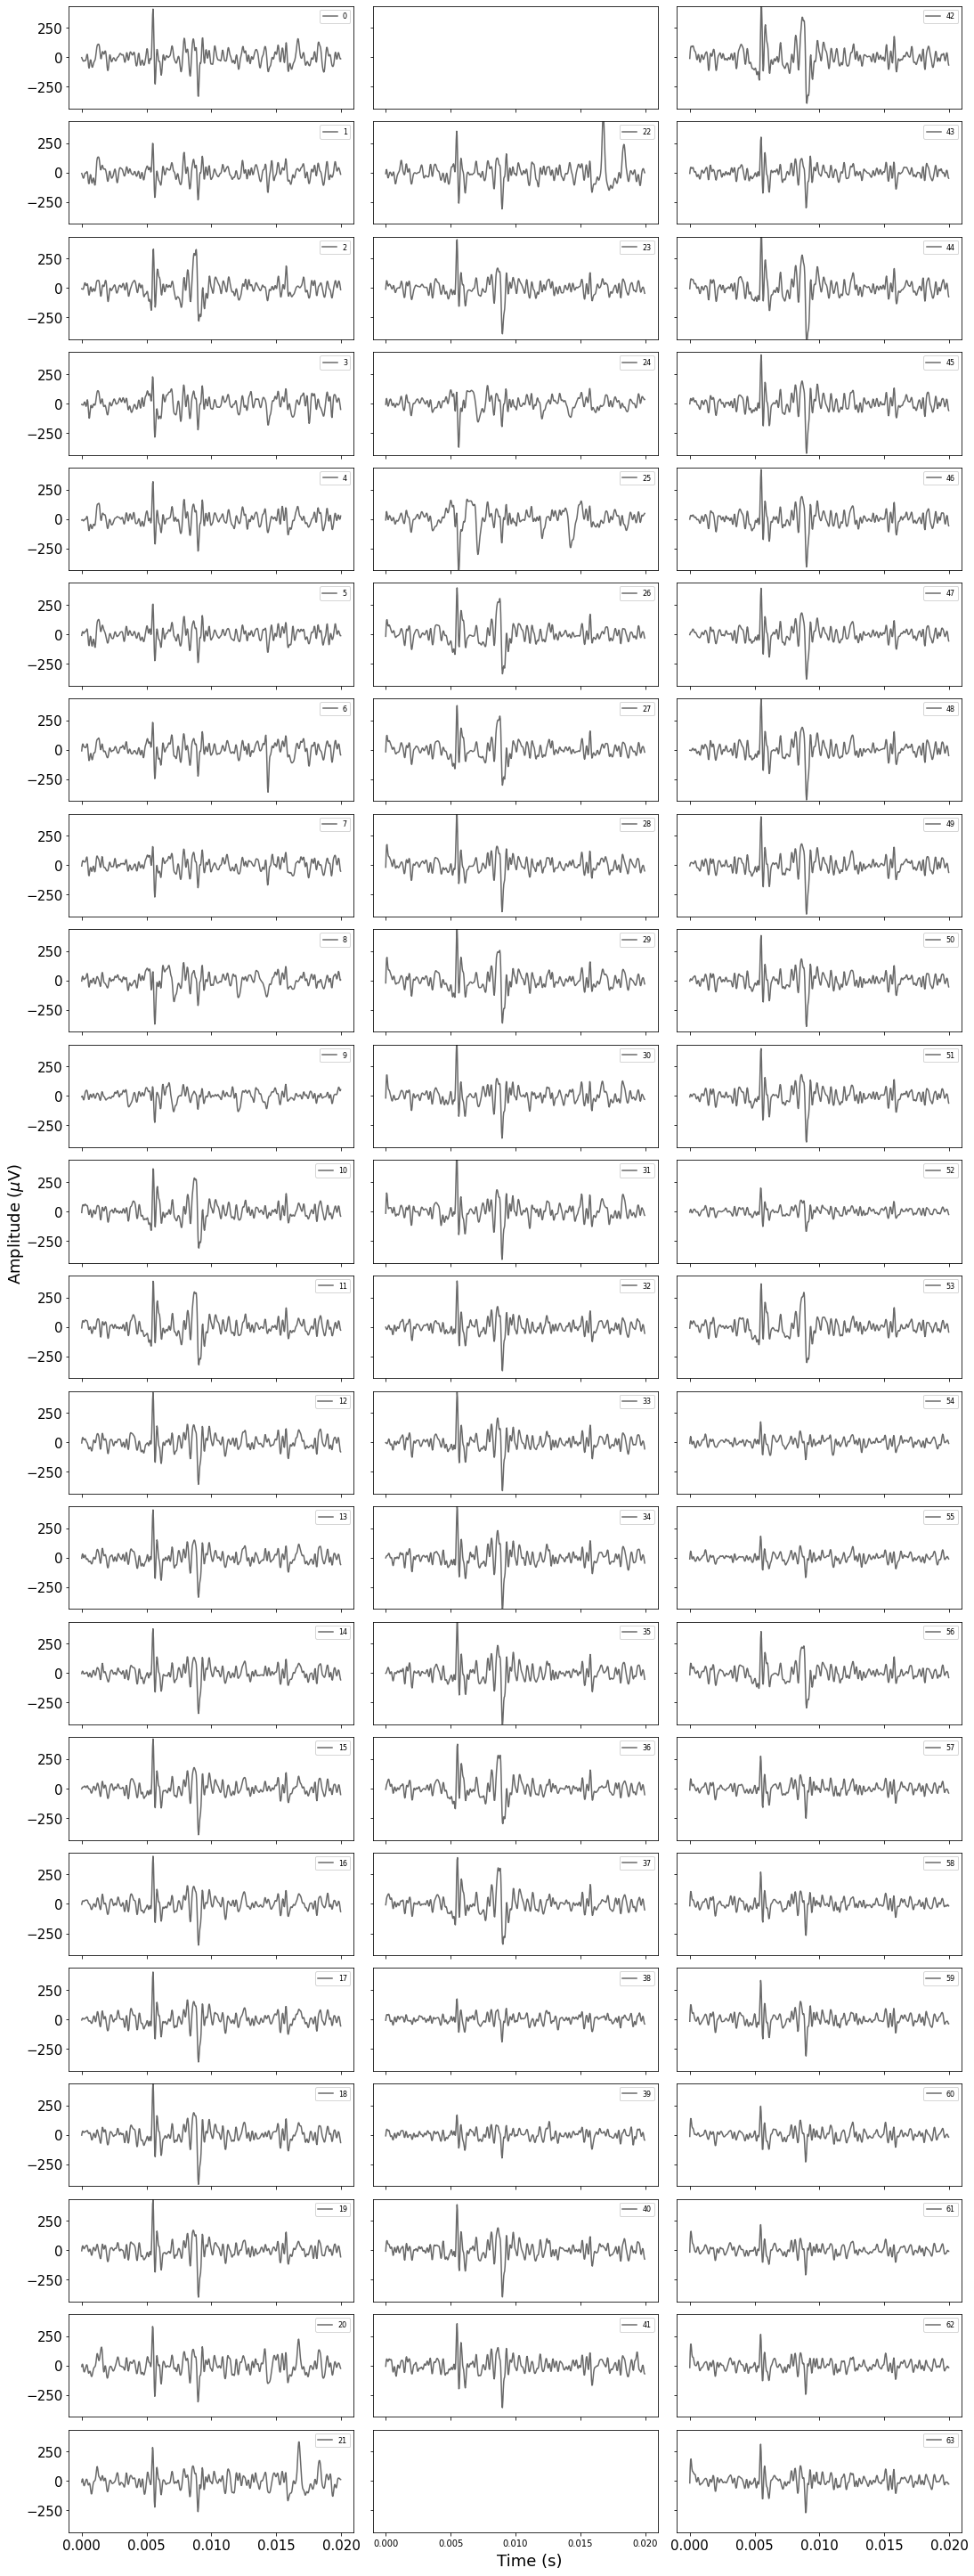

In [16]:
def grid_plot_filtered(columns, start, end):
    start = int(start*30000)
    end = int(end*30000)
    display(HTML('<hr><h4>Plotting channel: '))
    fig, ax = plt.subplots (len(columns[0]),int(columns.shape[0]), figsize =(15,40), sharex = True, sharey = True)
    for j in np.arange (0,columns.shape[0]):
        for i,col in enumerate(columns[j]): 
            if j == 1: # Offset for middle row (grid is 66 panels, but we only have 64 channels. Middle row is shorter) 
                i = i + 1
            print(col, end = ' ')
            ax[i][j].plot(xs[start:end]/fs, filtered.iloc[start:end,col], color = 'dimgray', 
                            label=str(col)) # filtered Signal
            handles, labels = ax[i][j].get_legend_handles_labels()
            ax[i][j].legend(handles, labels, loc = 'upper right', fontsize = 8, shadow = False)
            y_lims = ax[i][j].get_ylim()
            ax[i][j].set_ylim(y_lims[0] - abs(y_lims[0]) * 0.1, y_lims[1] + abs(y_lims[1]) * 0.1)
            ax[i][j].set_ylim(filtered_stats.means[col] - filtered_stats.rngs[col]*0.75, 
                              filtered_stats.means[col] + filtered_stats.rngs[col]*0.75)
            ax[i][j].tick_params (labelsize = 15)
            plt.tight_layout()
    fig.text(0.0, 0.5, r'Amplitude ($\mu$V)', ha='center', rotation='vertical', fontsize = 18)
    fig.text(0.5, 0.0, 'Time (s)', va='center',  fontsize = 18)
    plt.savefig (datafile.replace('.h5','_filtered' + str(chan_num[1]) + '.png'))
    display(HTML('<hr>'))

grid_plot_filtered(columns, start_time, end_time)